In [1]:
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import pylab as pl
import matplotlib.pyplot as plt
import scipy.stats as st

In [3]:
window = tk.Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
fileName = filedialog.askopenfilename(title="Select file",
                    filetypes=(("CSV files", "*.csv"),
                               ("All files", "*.*")),
                    parent=window)
my_data = pd.read_csv(fileName)
print('\n', my_data)


        phstat  phospyr
0           2        2
1           3        2
2           2        2
3           2        2
4           3        2
...       ...      ...
98644       2        2
98645       2        2
98646       1        2
98647       2        2
98648       4        2

[98649 rows x 2 columns]


In [4]:
print(my_data.info())
print(my_data.head(12))
print(my_data.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98649 entries, 0 to 98648
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   phstat   98649 non-null  int64
 1   phospyr  98649 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB
None
    phstat  phospyr
0        2        2
1        3        2
2        2        2
3        2        2
4        3        2
5        3        2
6        4        2
7        3        2
8        2        2
9        1        2
10       1        2
11       1        1
['phstat', 'phospyr']


In [5]:
my_data.describe().T

,count,mean,std,min,25%,50%,75%,max
phstat,98649.0,2.147016,1.084589,1.0,1.0,2.0,3.0,9.0
phospyr,98649.0,1.955712,0.519640,1.0,2.0,2.0,2.0,9.0


In [6]:
pd.crosstab(my_data['phospyr'], my_data['phstat']).T


phospyr,1,2,7,9
phstat,,,,
1,1512,32175,53,14
2,1764,28008,133,33
3,2195,22568,192,54
4,1476,5822,26,12
5,827,1476,11,8
7,8,118,76,8
9,11,59,2,8


In [7]:
my_data.phstat.value_counts()


1    33754
2    29938
3    25009
4     7336
5     2322
7      210
9       80
Name: phstat, dtype: int64

In [8]:
my_data.phospyr.value_counts()


2    90226
1     7793
7      493
9      137
Name: phospyr, dtype: int64

In [11]:
cut_df=my_data[(my_data.phstat < 7) & (my_data.phospyr < 7)]
print(cut_df.phstat.value_counts())
print(cut_df.phospyr.value_counts())

1    33687
2    29772
3    24763
4     7298
5     2303
Name: phstat, dtype: int64
2    90049
1     7774
Name: phospyr, dtype: int64


In [12]:
np.round(cut_df.describe().T[['count', 'mean', 'std', 'min', 'max']], 2)


,count,mean,std,min,max
phstat,97823.0,2.13,1.04,1.0,5.0
phospyr,97823.0,1.92,0.27,1.0,2.0


The ANOVA test has important assumptions
 that must be satisfied in order
 for the associated p-value to be valid.
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups
 are all equal. This property is known as
 homoscedasticity.


In [14]:

st.f_oneway(cut_df['phstat'][my_data['phospyr']==1],
            cut_df['phstat'][my_data['phospyr']==2])

F_onewayResult(statistic=3470.661816192353, pvalue=0.0)

In [16]:
cut_df['hosp']=my_data.phospyr
cut_df=pd.get_dummies(cut_df, columns=['hosp'])
cut_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97823 entries, 0 to 98648
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   phstat   97823 non-null  int64
 1   phospyr  97823 non-null  int64
 2   hosp_1   97823 non-null  uint8
 3   hosp_2   97823 non-null  uint8
dtypes: int64(2), uint8(2)
memory usage: 2.4 MB


<ipython-input-16-dd89b2b12646>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_df['hosp']=my_data.phospyr


In [18]:
o1 = sm.OLS.from_formula("phstat ~ hosp_1", data=cut_df).fit()
# nice output >>
info_dict={'Observations' : lambda x: f"{int(x.nobs):d}",
        'Adj. R-sq.' : lambda x: f"{x.rsquared_adj:.3f}",
        'F' : lambda x: f"{x.fvalue:.1f}",
        'F p-value' : lambda x: f"{x.f_pvalue:.3f}"}
results_table = summary_col(results=o1,
                            float_format='%0.3f',
                            stars = True,
                            info_dict=info_dict,
                            regressor_order=['female','edu',
                                             'age','age2','eage'])
results_table.add_title('OLS Regression')
print('\n',results_table)


     OLS Regression
                phstat 
-----------------------
Intercept      2.072***
               (0.003) 
hosp_1         0.715***
               (0.012) 
R-squared      0.034   
R-squared Adj. 0.034   
Observations   97823   
Adj. R-sq.     0.034   
F              3470.7  
F p-value      0.000   
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


In [19]:
# hospitalized
np.round(o1.params.Intercept+o1.params.hosp_1, 3)

2.787

In [20]:
# non-hospitalized
np.round(o1.params.Intercept, 3)

2.072

In [21]:
# two-way tabulation >>
pd.crosstab(cut_df['phospyr'], cut_df['phstat'])

phstat,1,2,3,4,5
phospyr,,,,,
1,1512,1764,2195,1476,827
2,32175,28008,22568,5822,1476


<AxesSubplot:ylabel='Frequency'>

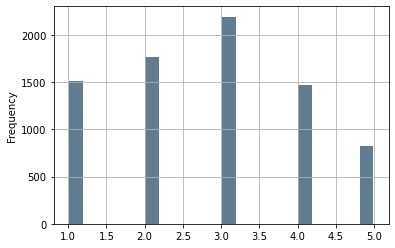

In [24]:
cut_df1=cut_df[cut_df['phospyr'] == 1]
cut_df2=cut_df[cut_df['phospyr'] == 2]

# histograms  >>
cut_df1['phstat'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')

<AxesSubplot:ylabel='Frequency'>

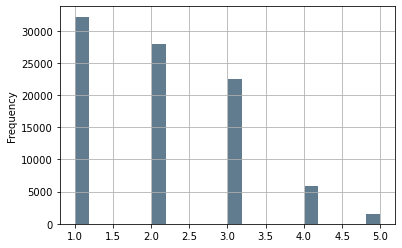

In [23]:
cut_df2['phstat'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')

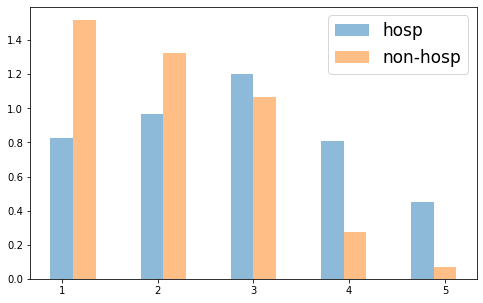

In [25]:
# the same in one window >>
bins = np.linspace(1, 5, 18)
plt.figure(figsize=(8,5))
plt.hist(cut_df1['phstat'], bins, density=True,
         align='left', alpha=0.5, label='hosp')
plt.hist(cut_df2['phstat'], bins, density=True,
         align='right',alpha=0.5, label='non-hosp')
plt.legend(loc='upper right', fontsize=17)

In [26]:
yhat=o1.predict(cut_df)

# regression line >>
f = lambda x: o1.params.Intercept+o1.params.hosp_1*x
# x values of line to plot
x = np.array([0,1])

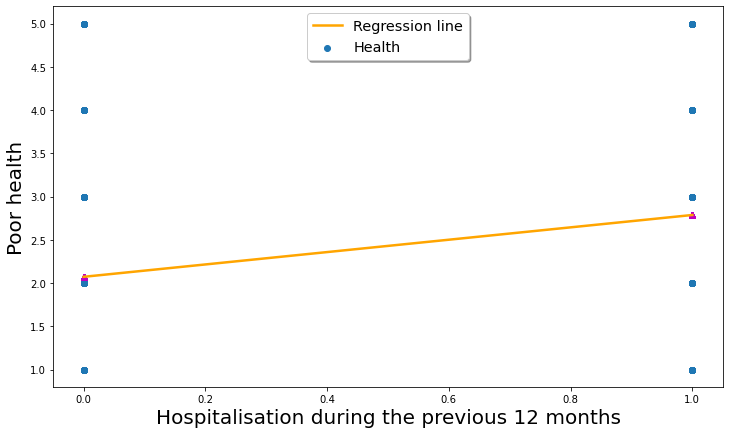

In [27]:
# graph >>
## run all the lines together >>
# a bit slowly with legend...
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
plt.plot(x,f(x),lw=2.5, c="orange",
         label="Regression line")
pl.scatter(y=cut_df['phstat'], x=cut_df['hosp_1'],
           label='Health')
pl.scatter(y=yhat, x=cut_df['hosp_1'],
           color='m', marker='^')
plt.ylabel('Poor health', fontsize=20)
plt.xlabel('Hospitalisation during the previous 12 months',
           fontsize=20)
ax.legend(loc='upper center', shadow=True, fontsize='x-large')

In [28]:
o2 = sm.OLS.from_formula("phstat ~ hosp_1 + hosp_2", data=cut_df).fit()

results_table = summary_col(results=[o1,o2],
                            float_format='%0.3f',
                            stars = True,
                            info_dict=info_dict,
                            regressor_order=['female','edu',
                                             'age','age2','eage'])
results_table.add_title('OLS Regression')
print('\n',results_table)


          OLS Regression
               phstat I phstat II
---------------------------------
Intercept      2.072*** 1.620*** 
               (0.003)  (0.004)  
hosp_1         0.715*** 1.167*** 
               (0.012)  (0.008)  
hosp_2                  0.452*** 
                        (0.005)  
R-squared      0.034    0.034    
R-squared Adj. 0.034    0.034    
Observations   97823    97823    
Adj. R-sq.     0.034    0.034    
F              3470.7   3470.7   
F p-value      0.000    0.000    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
